# Categorical features encoding -> xgb (~0.554)

[Yohan's Kernel](https://www.kaggle.com/yohanb/categorical-features-encoding-xgb-0-554)

<br>

Here we'll try to encode categorical features.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import r2_score

from IPython.display import display, HTML
# Shows all columns of a dataframe
def show_dataframe(X, rows = 2) :
    display(HTML(X.to_html(max_rows=rows)))

In [3]:
# Datasets
train = pd.read_csv('../../input/train.csv')
test = pd.read_csv('../../input/test.csv')

In [4]:
# Categorical features
cat_cols = []

for c in train.columns :
    if train[c].dtype == 'object' :
        cat_cols.append(c)
        
print('Categorical columns: ', cat_cols)

# Duplicate features
d = {}; done = []
cols = train.columns.values

for c in cols: 
    d[c] = []
    
for i in range(len(cols)) :
    if i not in done :
        for j in range(i+1, len(cols)) :
            if all(train[cols[i]] == train[cols[j]]) :
                done.append(j)
                d[cols[i]].append(cols[j])
                
dub_cols = []

for k in d.keys() :
    if len(d[k]) > 0 :
        # print k, d[k]
        dub_cols += d[k]
        
print('Dublicates: ', dub_cols)

# Constant columns
const_cols = []

for c in cols :
    if len(train[c].unique()) == 1 :
        const_cols.append(c)
        
print('Constant cols: ', const_cols)

Categorical columns:  ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
Dublicates:  ['X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347', 'X382', 'X232', 'X279', 'X35', 'X37', 'X39', 'X302', 'X113', 'X134', 'X147', 'X222', 'X102', 'X214', 'X239', 'X76', 'X324', 'X248', 'X253', 'X385', 'X172', 'X216', 'X213', 'X84', 'X244', 'X122', 'X243', 'X320', 'X245', 'X94', 'X242', 'X199', 'X119', 'X227', 'X146', 'X226', 'X326', 'X360', 'X262', 'X266', 'X247', 'X254', 'X364', 'X365', 'X296', 'X299']
Constant cols:  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


Figures below show categorical features (on the left) sorted by means of **y**'s grouped by labels. On the right there are corrsponding **mean**'s, **std**'s (filled blue), **max**'s (green line) and **min**'s (red line).

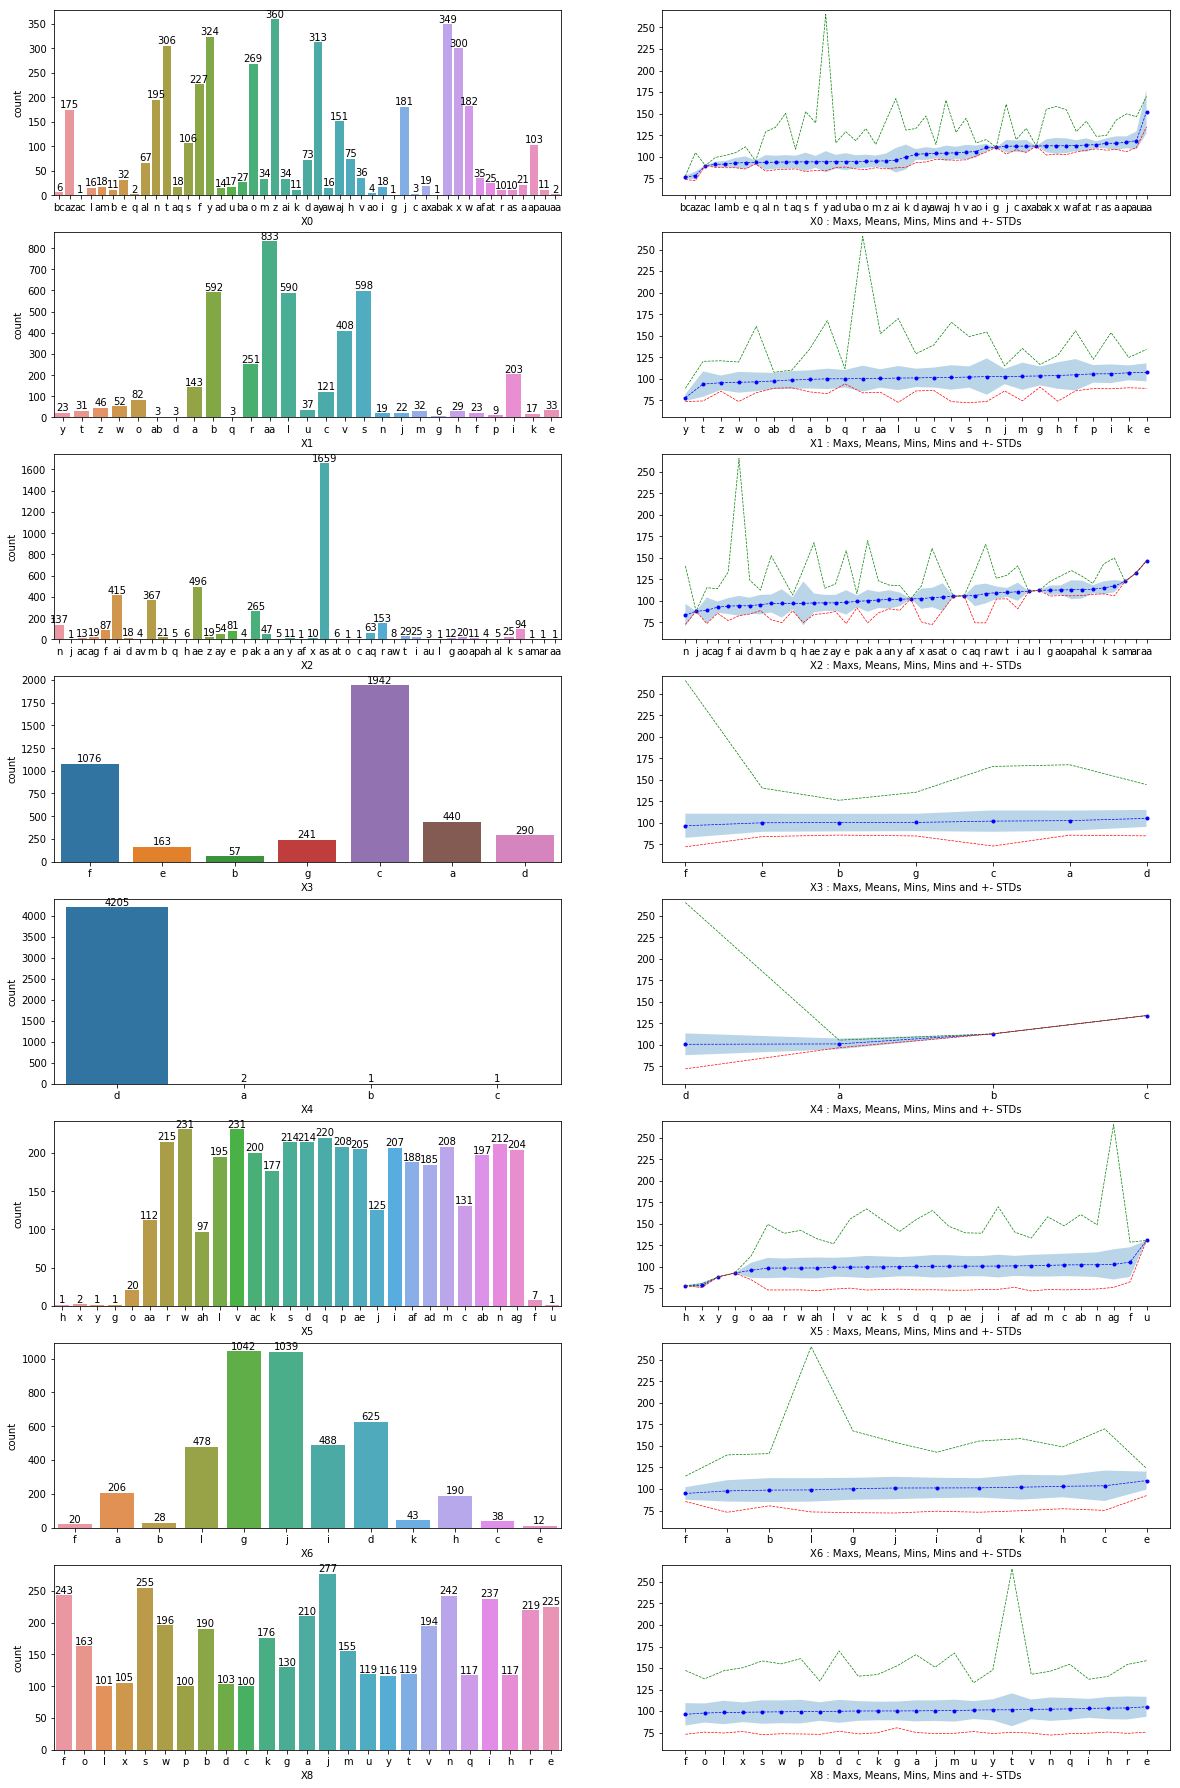

In [6]:
plt.figure(figsize=(20,32))

for i in range(len(cat_cols)) :
    c = cat_cols[i]
    
    means = train.groupby(c).y.mean()
    stds = train.groupby(c).y.std().fillna(0)
    maxs = train.groupby(c).y.max()
    mins = train.groupby(c).y.min()
    
    ddd = pd.concat([means, stds, maxs, mins], axis=1)
    ddd.columns = ['means', 'stds', 'maxs', 'mins']
    ddd.sort_values('means', inplace=True)
    
    plt.subplot(8, 2, 2*i+1)
    ax = sns.countplot(train[c], order=ddd.index.values)
    
    for p in ax.patches :
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom')
        
    plt.subplot(8, 2, 2*i+2)
    plt.fill_between(range(len(train[c].unique())),
                     ddd.means.values - ddd.stds.values,
                     ddd.means.values + ddd.stds.values,
                     alpha=0.3)
    
    plt.xticks(range(len(train[c].unique())),
               ddd.index.values)
    
    plt.plot(ddd.means.values, color='b', marker='.', linestyle='dashed', linewidth=0.7)
    plt.plot(ddd.maxs.values, color='g', linestyle='dashed', linewidth=0.7)
    plt.plot(ddd.mins.values, color='r', linestyle='dashed', linewidth=0.7)
    
    plt.xlabel(c + ' : Maxs, Means, Mins, Mins and +- STDs')
    plt.ylim(55, 270)

In [7]:
# Glue train + test
train['eval_set'] = 0
test['eval_set'] = 1
df = pd.concat([train, test], axis=0, copy=True)

# Reset index
df.reset_index(drop=True, inplace=True)

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


<br>

## Categorical feature encoding

In the next cell for every categorical column from **cat_cols** we'll find **mean** of **y's** for every label using **.groupby()**. Then we sort labels by values of **means**. Now, when labels are sorted, they can be encoded by numbers from *0* to *numbers of labels -1*.

In [9]:
def add_new_col(x) :
    if x not in new_col.keys() :
        # set n/2 x if is contained in test, but not in train
        # (n is the number of unique labels in train)
        # or an alternative could be -100 (something out of range [0; n-1])
        return int(len(new_col.keys())/2)
    return new_col[x] # rank of the label

for c in cat_cols :
    
    # get labels and corresponding means
    new_col = train.groupby(c).y.mean().sort_values().reset_index()
    
    # make a dictionary, where key is a label and value is the rank of that label
    new_col = new_col.reset_index().set_index(c).drop('y', axis=1)['index'].to_dict()
    
    # add new column to the dataframe
    df[c + '_new'] = df[c].apply(add_new_col)
    
# drop old categorical columns
df_new = df.drop(cat_cols, axis=1)

# show the result
show_dataframe(df_new, 5)

,ID,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X14,X140,X141,X142,X143,X144,X145,X146,X147,X148,X15,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X16,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X17,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X18,X180,X181,X182,X183,X184,X185,X186,X187,X189,X19,X190,X191,X192,X194,X195,X196,X197,X198,X199,X20,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X21,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X22,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X23,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X24,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X26,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X27,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X28,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X29,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X30,X300,X301,X302,X304,X305,X306,X307,X308,X309,X31,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X32,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X33,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X34,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X35,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X36,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X37,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X38,X380,X382,X383,X384,X385,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,eval_set,y,X0_new,X1_new,X2_new,X3_new,X4_new,X5_new,X6_new,X8_new
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130.81,22,15,24,5,0,28,5,1
1,6,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,88.53,22,1,7,1,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

<br>

## Train-test split

In [10]:
X = df.drop(list((set(const_cols) | set(dub_cols) | set(cat_cols))), axis=1)

# Train
X_train = X[X.eval_set == 0]
y_train = X_train.pop('y')
X_train = X_train.drop(['eval_set', 'ID'], axis=1)

# Test
X_test = X[X.eval_set == 1]
X_test = X_test.drop(['y', 'eval_set', 'ID'], axis=1)

# Base score
y_mean = y_train.mean()

# Shapes
print('Shape X_train: {}\nShape X_test: {}'.format(X_train.shape, X_test.shape))

Shape X_train: (4209, 319)
Shape X_test: (4209, 319)


<br>

## Model (XGBoost)

In [11]:
### Regressor

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 100,
    'eta': 0.005,
    'max_depth': 3,
    'subsample': 0.95,
    'colsample_bytree': 0.6,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': np.log(y_mean),
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train, np.log(y_train))
dtest = xgb.DMatrix(X_test)

# evaluation metric
def the_metric(y_pred, y) :
    y_true = y.get_label()
    return 'r2', r2_score(y_true, y_pred)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,
                   dtrain,
                   num_boost_round=2000,
                   nfold=3,
                   early_stopping_rounds=50,
                   feval=the_metric,
                   verbose_eval=100,
                   show_stdv=False)

num_boost_rounds = len(cv_result)
print('num_boost_rounds=' + str(num_boost_rounds))

# train model
model = xgb.train(dict(xgb_params, silent=0),
                  dtrain,
                  num_boost_round=num_boost_rounds)

# Predict on train and test
y_train_pred = np.exp(model.predict(dtrain))
y_pred = np.exp(model.predict(dtest))

print('First 5 predicted test values: ', y_pred[:5])

C:\Users\shkim\AppData\Local\conda\conda\envs\TF_VS_36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-r2:0.00207033	train-rmse:0.121493	test-r2:0.000778667	test-rmse:0.121484
[100]	train-r2:0.398274	train-rmse:0.094339	test-r2:0.394733	test-rmse:0.0945523
[200]	train-r2:0.548658	train-rmse:0.0817037	test-r2:0.542064	test-rmse:0.0822397
[300]	train-r2:0.60715	train-rmse:0.076225	test-r2:0.597211	test-rmse:0.077123
[400]	train-r2:0.631606	train-rmse:0.0738143	test-r2:0.618201	test-rmse:0.0750827
[500]	train-r2:0.643524	train-rmse:0.072611	test-r2:0.626567	test-rmse:0.074254
[600]	train-r2:0.65089	train-rmse:0.0718573	test-r2:0.630346	test-rmse:0.0738767
[700]	train-r2:0.656432	train-rmse:0.071285	test-r2:0.632145	test-rmse:0.0736967
[800]	train-r2:0.660769	train-rmse:0.0708337	test-r2:0.632971	test-rmse:0.0736137
[900]	train-r2:0.664539	train-rmse:0.0704387	test-r2:0.633259	test-rmse:0.0735853
num_boost_rounds=941
[11:21:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fi

Mean error =  0.3105792587254895
Train r2 =  0.5994634188454455


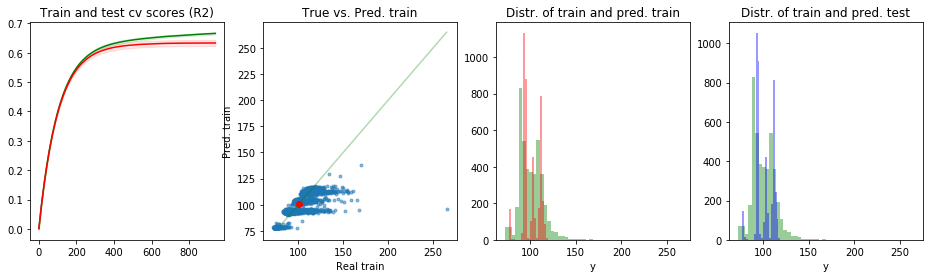

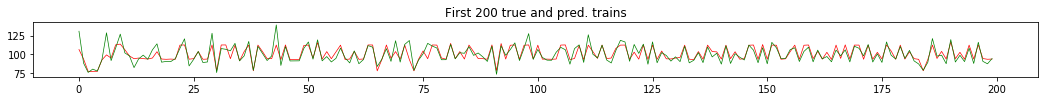

In [38]:
plt.figure(figsize=(16,4))

plt.subplot(1, 4, 1)

train_scores = cv_result['train-r2-mean']
train_stds = cv_result['train-r2-std']
plt.plot(train_scores, color='green')
plt.fill_between(range(len(cv_result)), 
                 train_scores - train_stds,
                 train_scores + train_stds,
                 alpha=0.1,
                 color='green')

test_scores = cv_result['test-r2-mean']
test_stds = cv_result['test-r2-std']
plt.plot(test_scores, color='red')
plt.fill_between(range(len(cv_result)),
                 test_scores - test_stds,
                 test_scores + test_stds,
                 alpha=0.1,
                 color='red')

plt.title('Train and test cv scores (R2)')

##########################################

plt.subplot(1, 4, 2)
plt.title('True vs. Pred. train')
plt.plot([80, 265], [80, 265], color='g', alpha=0.3)
plt.scatter(x=y_train, y=y_train_pred, marker='.', alpha=0.5)
plt.scatter(x=[np.mean(y_train)], y=[np.mean(y_train_pred)], marker='o', color='red')
plt.xlabel('Real train')
plt.ylabel('Pred. train')

##########################################

plt.subplot(1, 4, 3)
sns.distplot(y_train, kde=False, color='g')
sns.distplot(y_train_pred, kde=False, color='r')
plt.title('Distr. of train and pred. train')

##########################################

plt.subplot(1, 4, 4)
sns.distplot(y_train, kde=False, color='g')
sns.distplot(y_pred, kde=False, color='b')
plt.title('Distr. of train and pred. test')

##########################################

plt.figure(figsize=(18,1))
plt.plot(y_train_pred[:200], color='r', linewidth=0.7)
plt.plot(y_train[:200], color='g', linewidth=0.7)
plt.title('First 200 true and pred. trains')

print('Mean error = ', np.mean(y_train - y_train_pred))
print('Train r2 = ', r2_score(y_train, y_train_pred))

<br>

## Feature importance

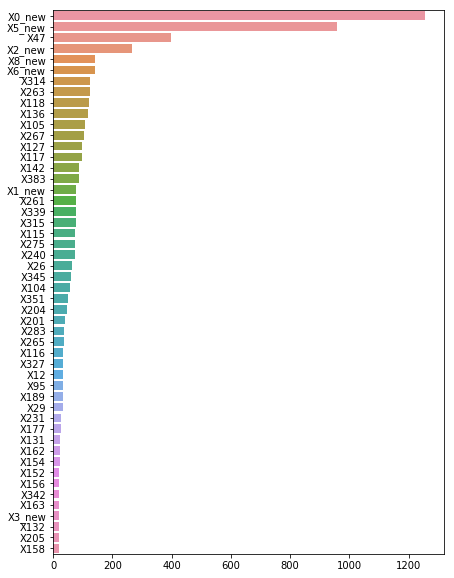

In [40]:
# First 50 features
features_score = pd.Series(model.get_fscore()).sort_values(ascending=False)[:50]
plt.figure(figsize=(7,10))
sns.barplot(x=features_score.values,
            y=features_score.index.values,
            orient='h')

In [41]:
output = pd.DataFrame({'id': test['ID'].astype(np.int32),
                       'y': y_pred})
output.to_csv('output06_subm.csv', index=False)